<h1 align="center">Regression Model for Predicting Wine Quality</h1>

## Introduction

This notebook aims to accomplish [Regression Model](https://algorit.ma/course/regression-models/) course at Algoritma. The dataset used is obtained from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wine+Quality), i.e. Wine Quality Data Set. There are two datasets provided (red wine and white wine), but **only the white wine one will be discussed in this notebook.**

### Dataset Background

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult: [Web Link](http://www.vinhoverde.pt/en/) or the reference [Cortez et al., 2009](http://dx.doi.org/10.1016/j.dss.2009.05.016). Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

### Aim

The goal is to model wine quality based on physicochemical tests.

### Objectives

a. To solve the final model equation

b. To output the statistical values (adjusted) R-squared and Root Mean Squared Error (RMSE)

c. To examine the model including statistics and visualizations:

- Assess linearity of model (parameters)
- Assess serial independence of errors
- Assess heteroscedasticity
- Assess normality of residual distribution
- Assess multicollinearity

d. To interpretate the model

e. To consider other factors, such as:

- Are there any outliers?
- Are there missing values?
- How will categorical variables be handled?

f. To test the model using dataset test and discuss the results

### Structure

This article is arranged as follows.

1. [Introduction](#intro)
2. [Metadata](#meta)
3. [Preparation](#prep)
4. [Exploratory Data Analysis](#eda)
5. [Modelling](#model)
6. [Model Improvements](#modimprov)
7. [Results and Discussions](#resdis)
8. [Conclusions](#conc)

## Metadata

There are 12 columns available in the dataset. They are briefly described below or you can read in [this file](winequality.names). For more information, read [Cortez et al., 2009](http://dx.doi.org/10.1016/j.dss.2009.05.016).

Input variables (based on physicochemical tests):

1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol

Output variable (based on sensory data):

12. quality (score between 0 and 10)

### Source

Paulo Cortez, University of Minho, Guimarães, Portugal, http://www3.dsi.uminho.pt/pcortez
A. Cerdeira, F. Almeida, T. Matos and J. Reis, Viticulture Commission of the Vinho Verde Region(CVRVV), Porto, Portugal @2009

### Relevant Papers

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

Available at: [Web Link](http://dx.doi.org/10.1016/j.dss.2009.05.016)

## Preparation

Load all necessary libraries and prepare the performance indicators and all necessary functions.


In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.stats.stats import pearsonr
from scipy.stats import shapiro
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import influence_plot
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

%matplotlib inline

In [24]:
def indicator(model, X_train, y_train, y_pred, y_true):
    Rsq = model.score(X_train, y_train)
    n = X_train.shape[0]
    p = X_train.shape[1]
    adjRsq = 1 - (1- Rsq**2)*((n-1)/(n-p-1))
    print('Adj R-squared:', adjRsq)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_pred, y_true))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_pred, y_true))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_pred, y_true)))

def Metrics(y_pred, y_true):
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_pred, y_true))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_pred, y_true))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_pred, y_true)))
    corPredAct = pearsonr(y_pred, y_true)
    print("Correlation:", corPredAct)
    print("R^2 between y_pred & y_true:", corPredAct[0]**2)

import scipy.stats
def CheckNormal(model, X, y):
    y_hat = model.predict(X)
    residue = y - y_hat
    fig, ax = plt.subplots(figsize=(12,8))
    fig = plt.hist(residue, bins=30, edgecolor='black', linewidth=1.2)
    shaptest = shapiro(residue)[1]
    print('Shapiro-Wilk normality test\n')
    print('p-value:', shaptest)
    if (shaptest <= 0.05):
        print("H0 rejected: the residuals are NOT distributed normally")
    else:
        print("H0 failed to reject: the residuals ARE distributed normally")

from statsmodels.stats.diagnostic import het_breuschpagan
def CheckHomos(model, X, y):
    y_hat = model.predict(X)
    residue = y - y_hat
    
    fig, ax = plt.subplots(figsize=(12,8))
    fig = plt.scatter(y_hat, residue)
    fig = plt.axhline(y=0, color='r', linestyle='-')
#     plt.plot(np.arange(len(y_hat)), np.zeros(len(residue)), color = "red")

    
    BP = het_breuschpagan(residue, X)
    print("p-value:", BP[1])
    if (BP[1] <= 0.05):
        print("H0 rejected: Error variance spreads INCONSTANTLY/generating patterns(Heteroscedasticity)")
    else:
        print("H0 failed to reject: Error variance spreads CONSTANTLY (Homoscedasticity)")
        
def vif(X):
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [VIF(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    return vif

Load the dataset and show its head.

In [3]:
whiteDF = pd.read_csv('winequality-white.csv', delimiter=";")
whiteDF.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
whiteDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [5]:
whiteDF.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [6]:
whiteDF.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

## Exploratory Data Analysis

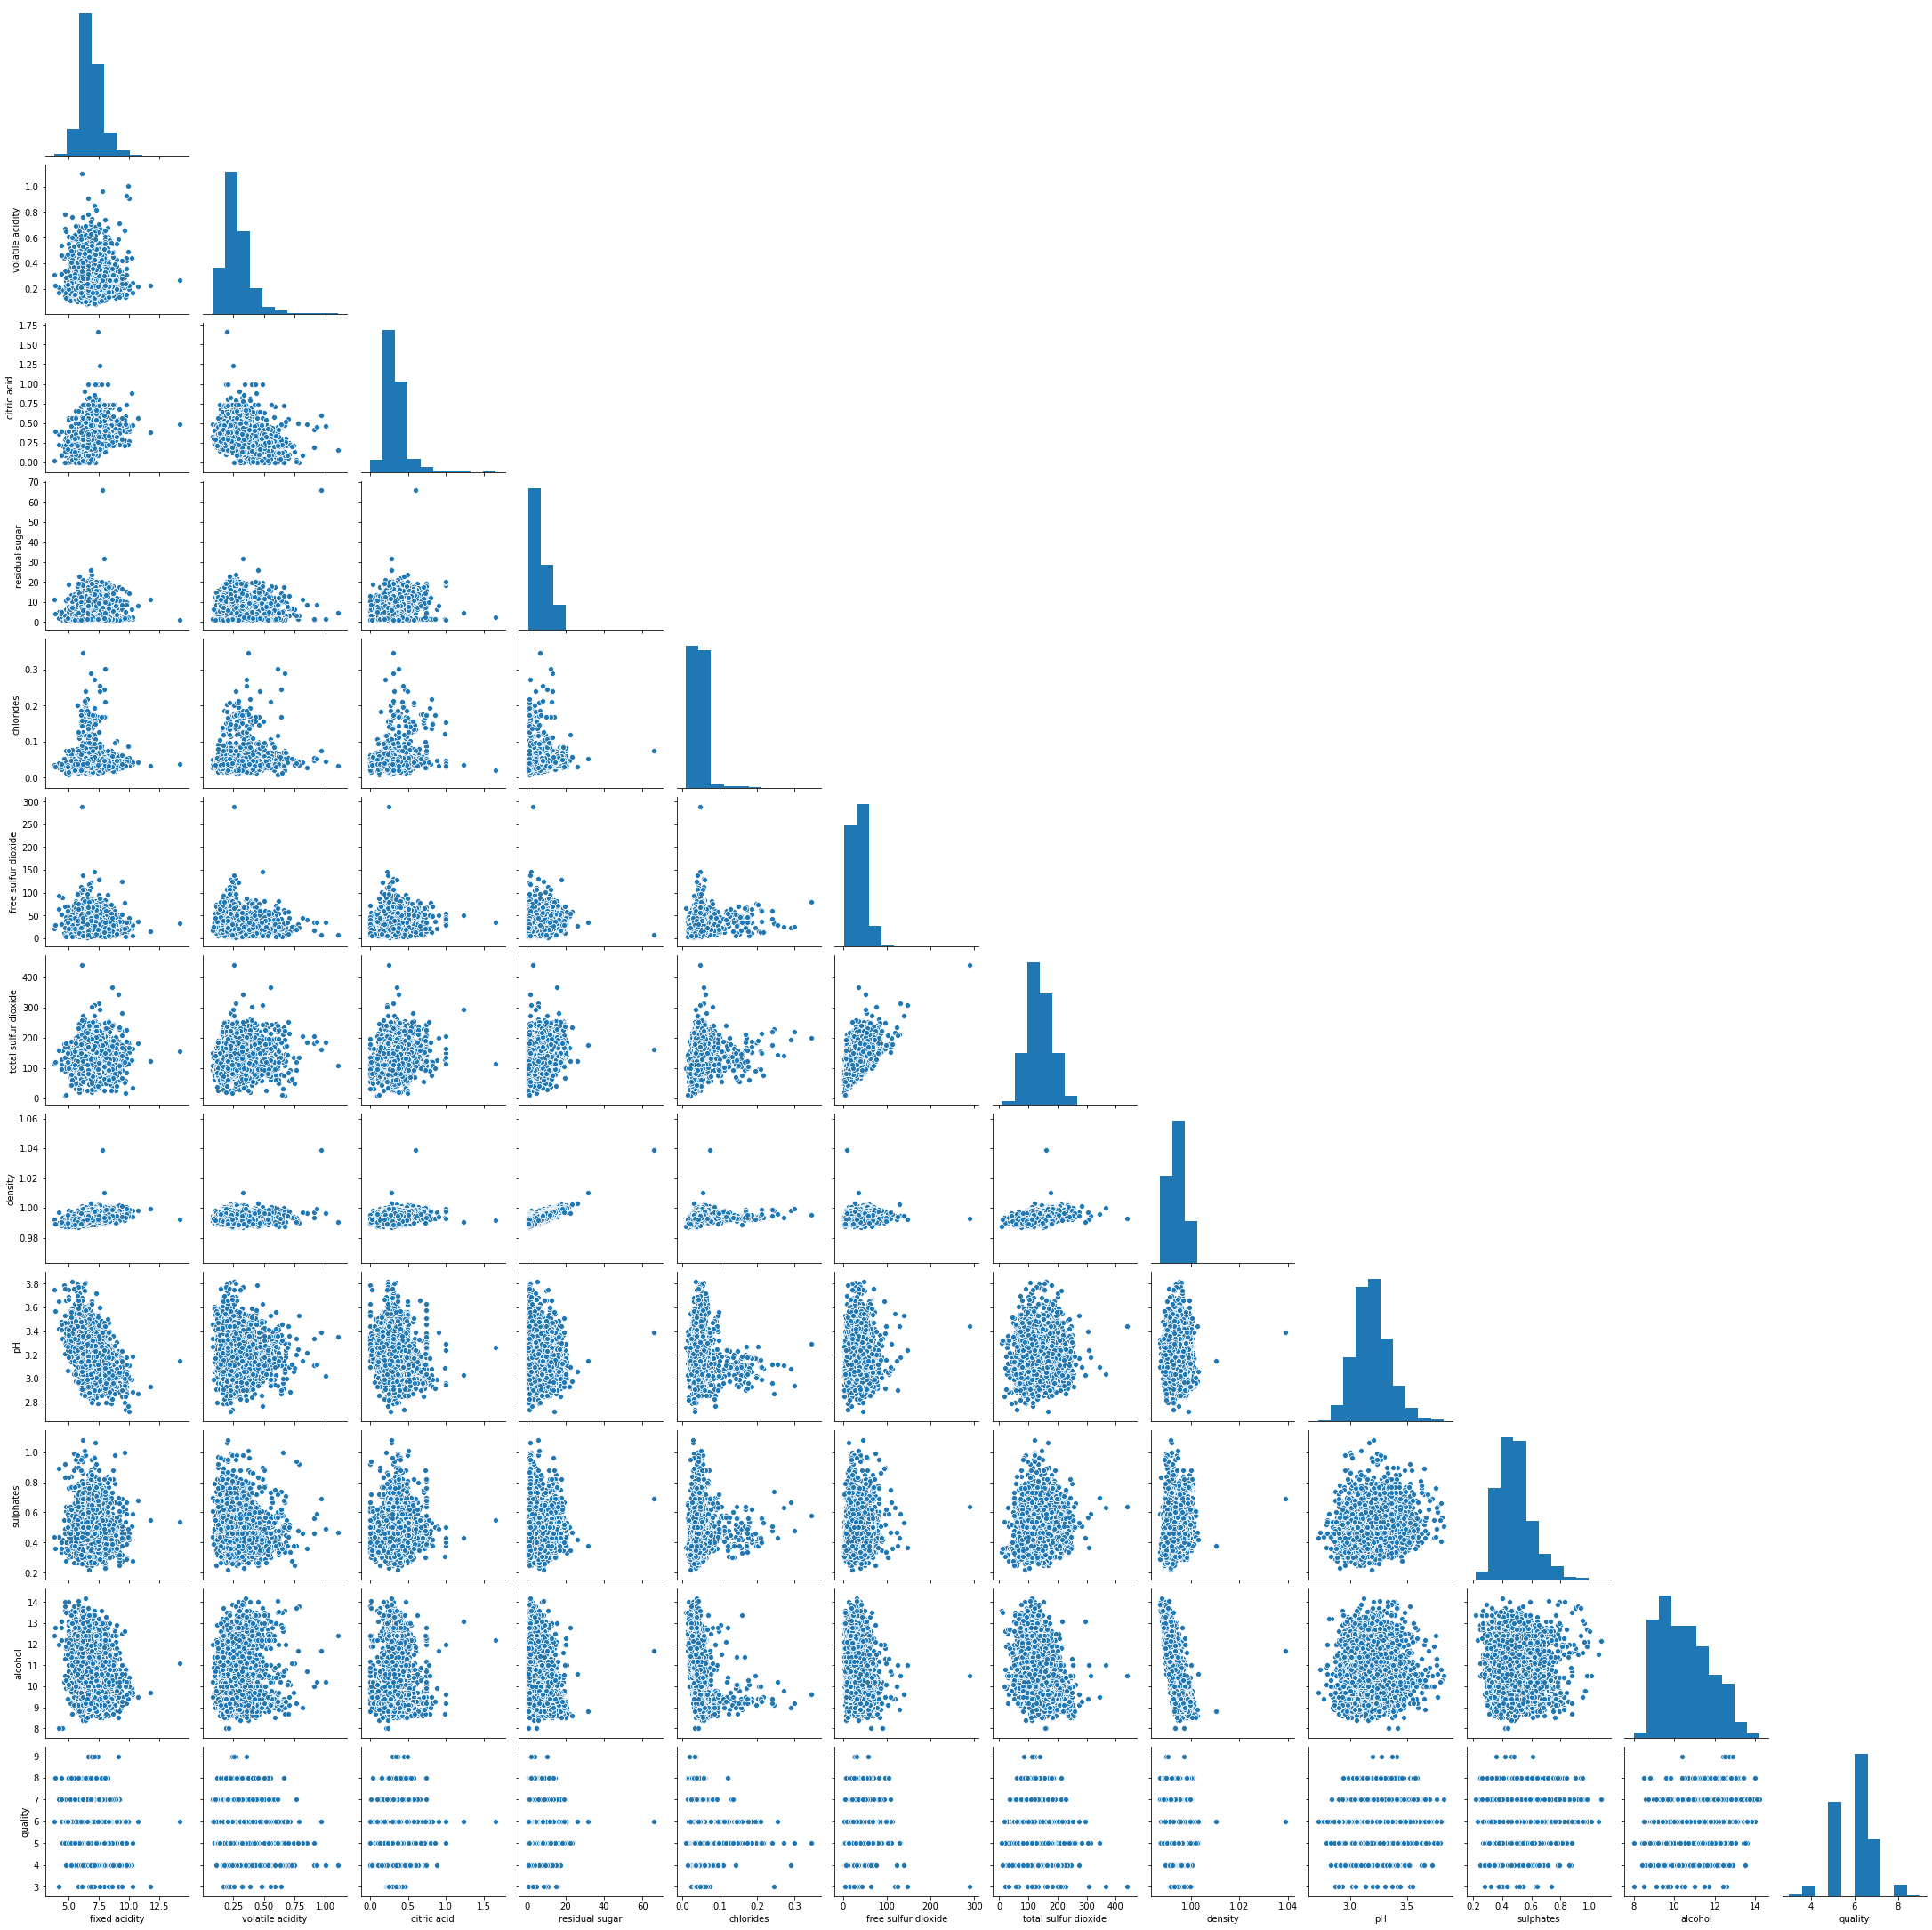

In [7]:
sns.pairplot(whiteDF, corner = True)

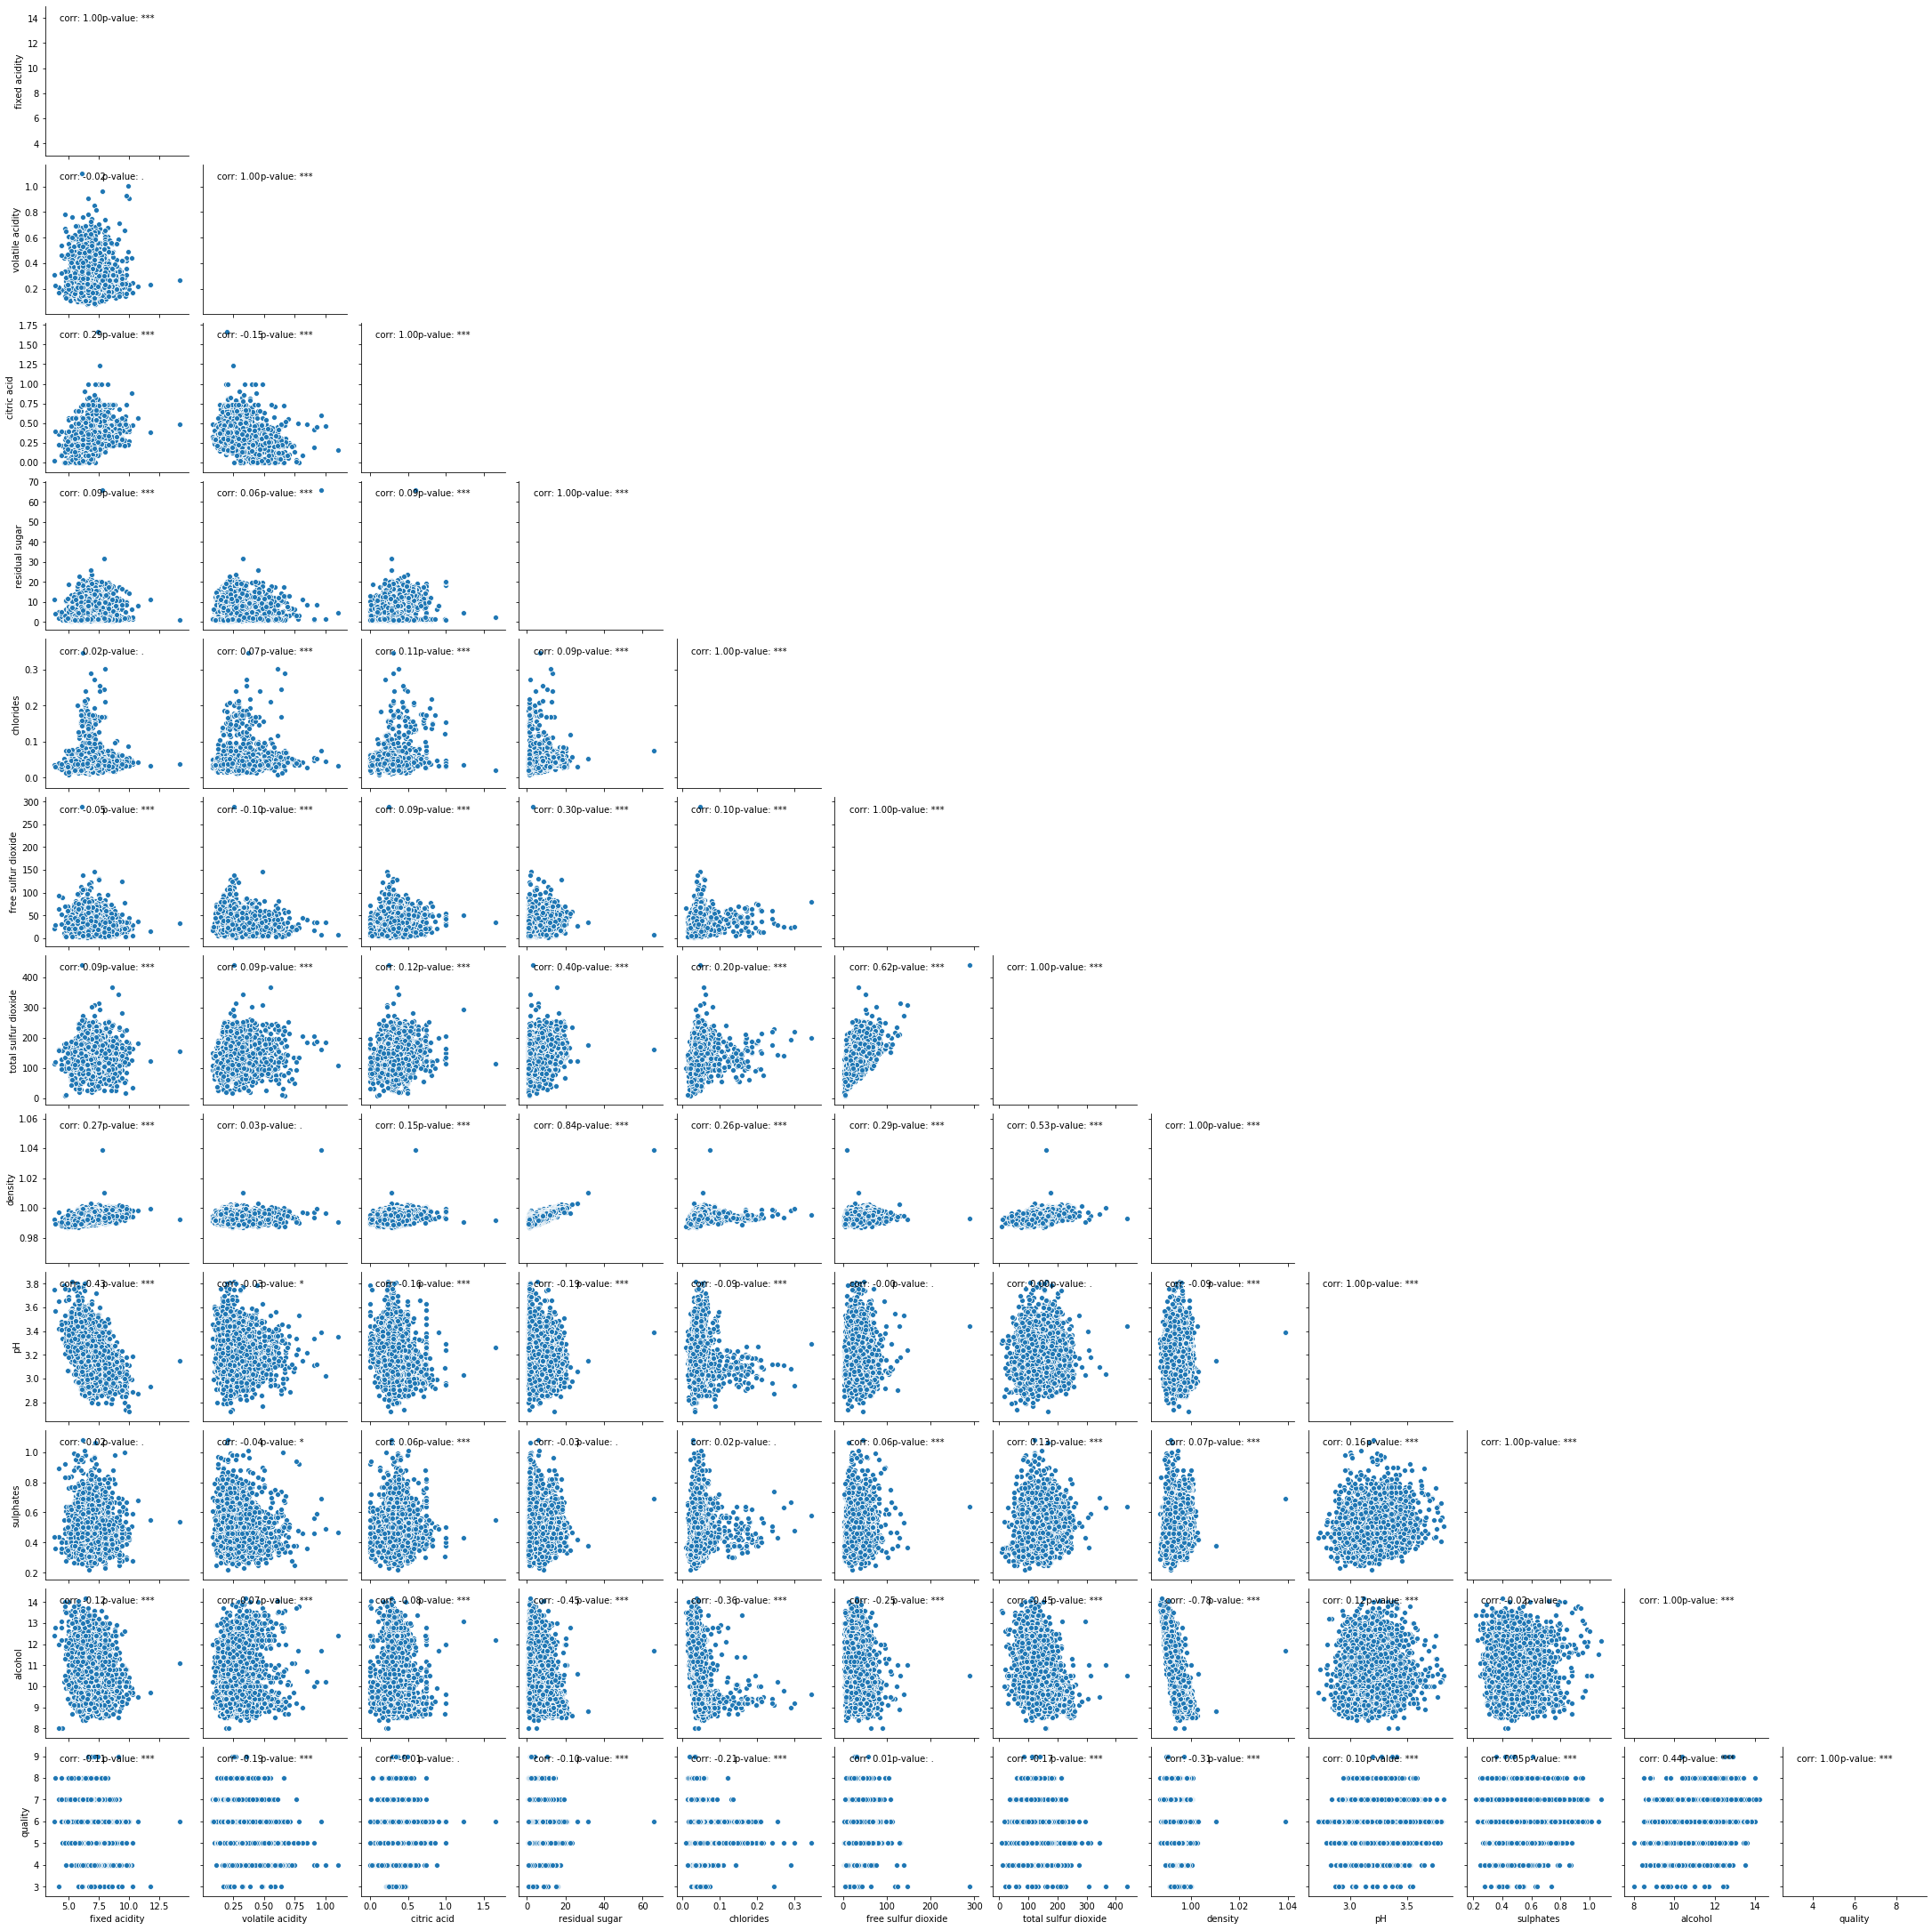

In [8]:
def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y)
    
    if (p < 0.05 and p >= 0.01):
        sign = "*"
    elif (p < 0.01 and p >= 0.001):
        sign = "**"
    elif (p < 0.001 and p >= 0):
        sign = "***"
    else:
        sign = "."
    
    ax = plt.gca()
    ax.annotate("corr: {:.2f} ".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate(f"p-value: {sign}",
                xy=(.4, .9), xycoords=ax.transAxes)

def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)
    
graph = sns.pairplot(whiteDF)
graph.map_upper(hide_current_axis)
graph.map_diag(hide_current_axis)
graph.map(corrfunc)

In [9]:
alpha = 0.05
for i in range(whiteDF.shape[1]-1):
    cor_i = pearsonr(whiteDF.quality, whiteDF.iloc[:,i])
    print("Correlation & p-value between quality and", whiteDF.columns[i], "is:")
    print(cor_i)
    if (cor_i[1] < alpha):
        print("significant")
    else:
        print("insignificant")
    print("\n")

Correlation & p-value between quality and fixed acidity is:
(-0.11366283071302202, 1.4798856790558785e-15)
significant


Correlation & p-value between quality and volatile acidity is:
(-0.19472296892113952, 4.673261270709255e-43)
significant


Correlation & p-value between quality and citric acid is:
(-0.0092090908839756, 0.5193459380152076)
insignificant


Correlation & p-value between quality and residual sugar is:
(-0.09757682889469574, 7.724004684826861e-12)
significant


Correlation & p-value between quality and chlorides is:
(-0.20993441094676826, 6.506541750083377e-50)
significant


Correlation & p-value between quality and free sulfur dioxide is:
(0.008158067123436294, 0.5681271459251901)
insignificant


Correlation & p-value between quality and total sulfur dioxide is:
(-0.17473721759706792, 6.991898124269822e-35)
significant


Correlation & p-value between quality and density is:
(-0.3071233127347374, 1.7279878711532392e-107)
significant


Correlation & p-value between qualit

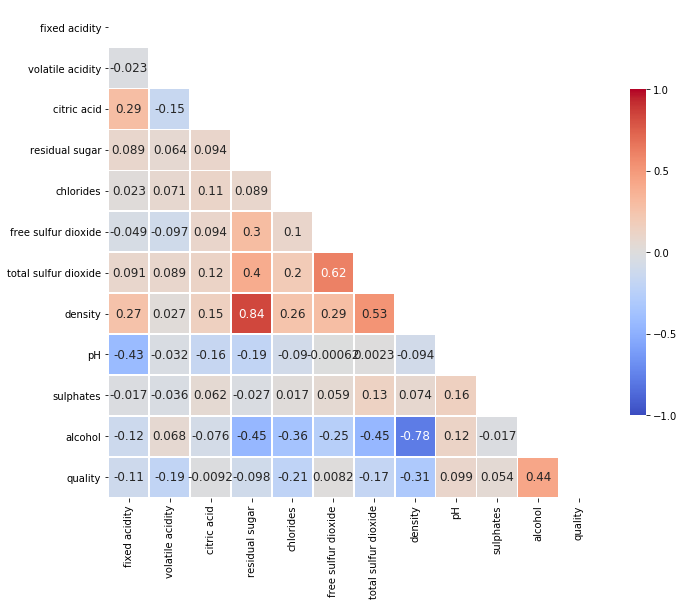

In [10]:
df_corr = whiteDF.corr()

# df_dummy = pd.get_dummies(redDF.htype)
# df = pd.concat([redDF, df_dummy], axis = 1)

mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 15))

heatmap = sns.heatmap(df_corr,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = "coolwarm",
                      cbar_kws = {'shrink': .4,
                                "ticks" : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})

#add the column names as labels
ax.set_yticklabels(df_corr.columns, rotation = 0)
ax.set_xticklabels(df_corr.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

## Modelling

### Splitting Train Datasets and Test Datasets

In [110]:
X = whiteDF.iloc[:,:-1]
y = whiteDF.quality

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [137]:
Xy_train = X_train.copy()
Xy_train['quality'] = y_train
Xy_train.reset_index(inplace=True)

4685    5
4589    6
2700    7
283     5
1014    5
       ..
4859    6
3264    6
1653    6
2607    6
2732    5
Name: quality, Length: 3918, dtype: int64

In [138]:
X_train = np.array(X_train)
X_train
y_train = np.array(y_train)
y_train

array([5, 6, 7, ..., 6, 6, 5])

In [114]:
y_test = np.array(y_test)

### Create the Model

In [139]:
model_white1a = LinearRegression().fit(X_train, y_train)

In [140]:
X_train1 = sm.add_constant(X_train)
model_white1b = sm.OLS(y_train, X_train1).fit()

In [82]:
model_white1b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     143.6
Date:                Sat, 22 Feb 2020   Prob (F-statistic):          4.19e-278
Time:                        01:23:33   Log-Likelihood:                -4353.6
No. Observations:                3918   AIC:                             8731.
Df Residuals:                    3906   BIC:                             8807.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        188.4593     25.649      7.348      0.000     138.173     238.746
x1             0.1070      0.026      4.088      0.000       0.056       0.158
x2            -1.8103      0.125    -14.516      0.000      -2.055      -1.566
x3            -0.0152      0.105     -0.144      0.885      -0.221       0.191
x4             0.0929      0.010      9.559      0.000       0.074       0.112
x5            -0.5567      0.597     -0.932      0.351      -1.728       0.614
x6             0.0044      0.001      4.737      0.000       0.003       0.006
x7            -0.0003      0.000     -0.675      0.500      -0.001       0.001
x8          -188.9926     25.998     -7.270      0.000    -239.963    -138.022
x9             0.8224      0.125      6.581      0.000       0.577       1.067
x10            0.6390      0.110      5.791      0.000       0.423       0.855
x11            0.1378      0.032      4.262      0.000       0.074       0.201
==============================================================================
Omnibus:                       96.797   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.345
Skew:                           0.139   Prob(JB):                     1.40e-43
Kurtosis:                       4.064   Cond. No.                     4.66e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.66e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Create the Assumptions

#### Normality

Shapiro-Wilk normality test

p-value: 1.6747679693410856e-16
H0 rejected: the residuals are NOT distributed normally


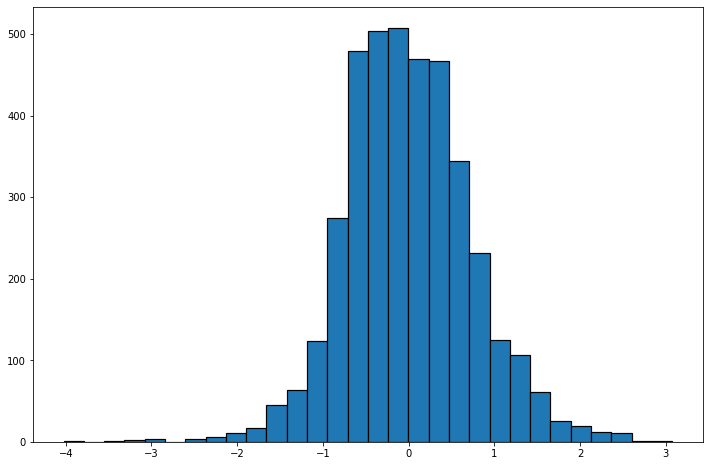

In [21]:
CheckNormal(model_white1a, X_train, y_train)

#### Homoscedasticity

p-value: 9.457775504794757e-211
H0 rejected: Error variance spreads INCONSTANTLY/generating patterns(Heteroscedasticity)


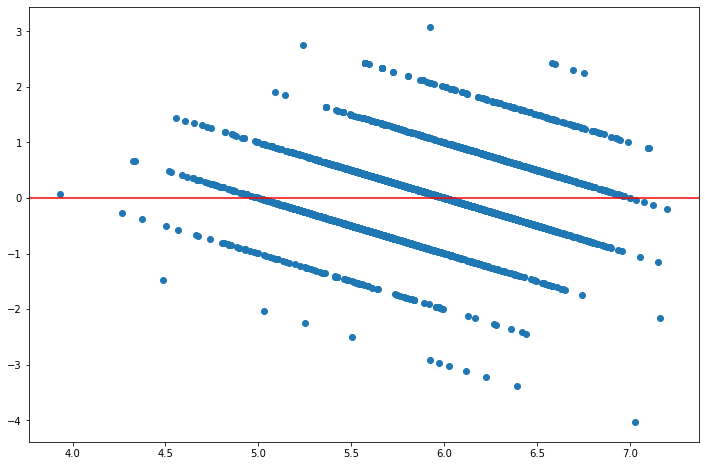

In [25]:
CheckHomos(model_white1a, X_train, y_train)

#### Multicollinearity

In [70]:
vif(X_train1)

,VIF Factor,features
0,4.755300e+06,const
1,3.371432e+00,fixed acidity
2,1.131041e+00,volatile acidity
3,1.148976e+00,citric acid
4,1.702978e+01,residual sugar
5,1.249064e+00,chlorides
6,1.806619e+00,free sulfur dioxide
7,2.324373e+00,total sulfur dioxide
8,4.197653e+01,density
9,2.565026e+00,pH


## Model Tuning

### Check Outliers

In [90]:
# Xy_train['y_hat'] = y_hat
# Xy_train['resid'] = residue

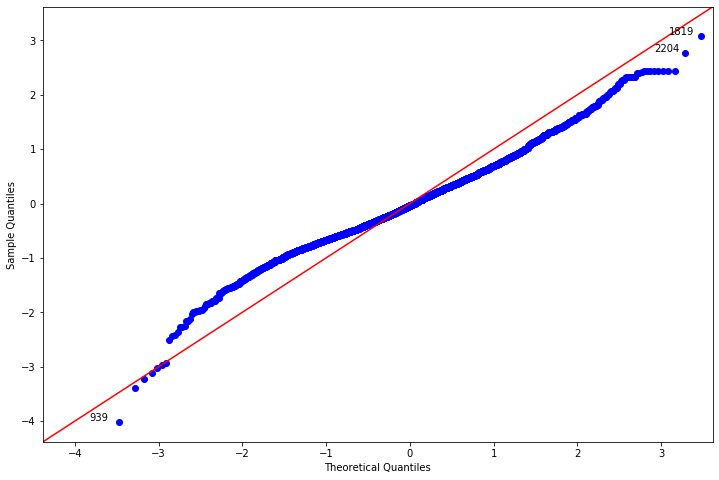

In [164]:
out_resids = np.where((model_white1b.resid > 2.6) | (model_white1b.resid < -4))
out_resids = list(out_resids[0][:])
xAx = [-3.85, 3.07, 2.9]

fig, ax = plt.subplots(figsize=(12,8))
fig = sm.qqplot(model_white1b.resid, line ='45', ax=ax)

for i, fill in enumerate(out_resids):
    plt.gca().annotate('{}'.format(fill),
                       xy = (xAx[i], model_white1b.resid[fill]),
                       xytext=(2,2), 
                       textcoords ="offset points")
plt.show()

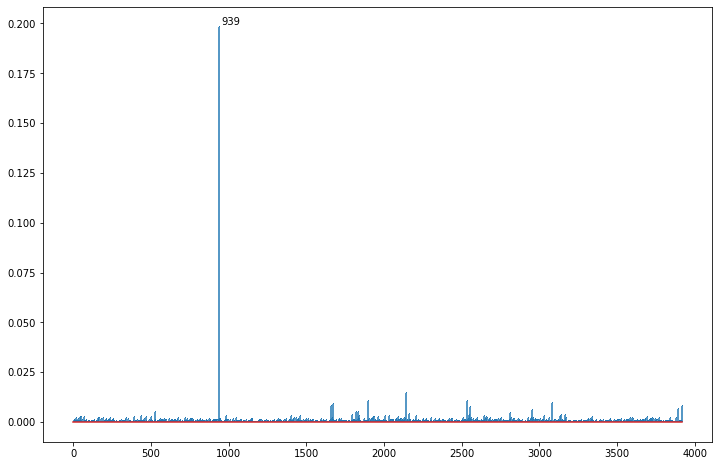

In [165]:
influence = model_white1b.get_influence()
#c is the distance and p is p-value
(c, p) = influence.cooks_distance
indices = np.where(c > 0.03)
indices = list(indices[0][:])
fig, ax = plt.subplots(figsize=(12,8))
fig = plt.stem(np.arange(len(c)), c, markerfmt=",", use_line_collection=True)
for i, idx in enumerate(indices):
    plt.gca().annotate('{}'.format(idx), 
                       xy=(idx, c[idx]), 
                       xytext=(2,2), 
                       textcoords ="offset points")

Text(0, 0.5, 'Residuals')

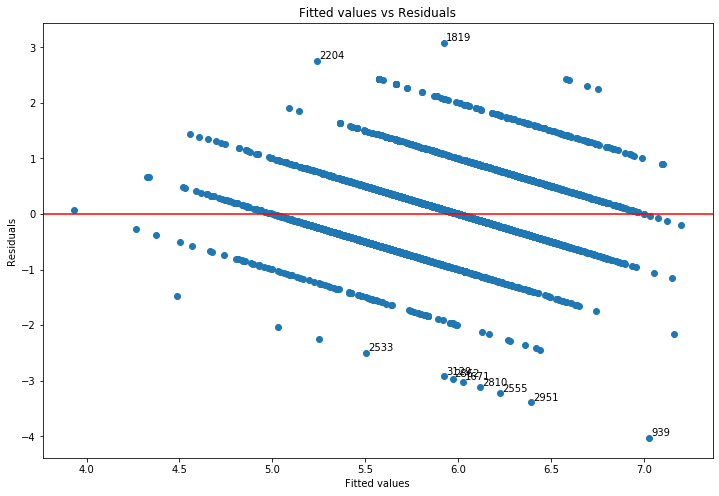

In [174]:
out_resids = np.where((model_white1b.resid > 2.5) | (model_white1b.resid < -2.5))
out_resids = list(out_resids[0][:])

fig, ax = plt.subplots(figsize=(12,8))
fig = plt.scatter(model_white1b.fittedvalues, model_white1b.resid)
fig = plt.axhline(y=0, color='r', linestyle='-')
for i, fill in enumerate(out_resids):
    plt.gca().annotate('{}'.format(fill), 
                       xy=(model_white1b.fittedvalues[fill], model_white1b.resid[fill]), 
                       xytext=(2,2), 
                       textcoords ="offset points")
plt.title('Fitted values vs Residuals')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

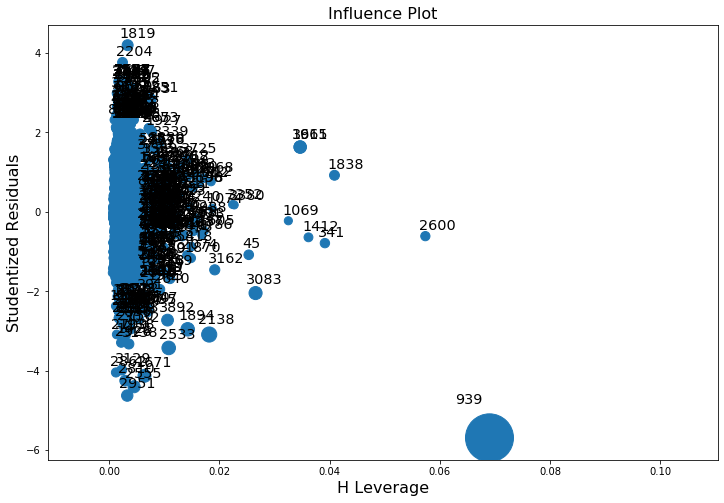

In [167]:
fig, ax = plt.subplots(figsize=(12,8))
fig = influence_plot(model_white1b, ax=ax, criterion="cooks", plot_alpha=1.0, alpha=0.03)
plt.show()

In [178]:
toRemove = [939, 1671, 1819, 2204, 2533, 2555, 2810, 2862, 2951, 3129]
Xy_train.iloc[toRemove,:]

,index,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
939,4745,6.1,0.26,0.25,2.90,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3
1671,251,8.5,0.26,0.21,16.20,0.074,41.0,197.0,0.99800,3.02,0.50,9.8,3
1819,774,9.1,0.27,0.45,10.60,0.035,28.0,124.0,0.99700,3.20,0.46,10.4,9
2204,904,6.9,0.21,0.28,2.40,0.056,49.0,159.0,0.99440,3.02,0.47,8.8,8
2533,2050,11.8,0.23,0.38,11.10,0.034,15.0,123.0,0.99970,2.93,0.55,9.7,3
2555,740,6.9,0.39,0.40,4.60,0.022,5.0,19.0,0.99150,3.31,0.37,12.6,3
2810,1229,8.3,0.33,0.42,1.15,0.033,18.0,96.0,0.99110,3.20,0.32,12.4,3
2862,3409,6.2,0.23,0.35,0.70,0.051,24.0,111.0,0.99160,3.37,0.43,11.0,3
2951,445,7.1,0.32,0.32,11.00,0.038,16.0,66.0,0.99370,3.24,0.40,11.5,3
3129,3087,6.1,0.20,0.34,9.50,0.041,38.0,201.0,0.99500,3.14,0.44,10.1,3


In [194]:
Xy_train_NoOut = Xy_train.copy()
Xy_train_NoOut = Xy_train_NoOut.drop(toRemove)
Xy_train_NoOut.reset_index(inplace=True)

In [ ]:
model.score(X_train, y_train)

In [ ]:
model._residues

In [ ]:
y_pred = model.predict(X_test)

In [ ]:


# plt.hist(residue)
sns.residplot(residue, y_test)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
X_train1 = sm.add_constant(X_train)
X_train1

In [ ]:
model1 = sm.OLS(y_train, X_train1)

In [ ]:
model1.resid

In [ ]:
results = model1.fit()

In [ ]:
results.summary()

In [ ]:
model1.predict(y_test)